# Example of detrending and geostrophic flow calculation
## Load modules

In [1]:
import Pkg
Pkg.activate("../..")
Pkg.instantiate()
using DIVAnd
using Dates
using Statistics
using Makie, CairoMakie, GeoMakie
using PhysOcean
using NCDatasets
using DataStructures
using ColorSchemes
include("../config.jl")

  Activating project at `~/Projects/Diva-Workshops`


"https://dox.uliege.be/index.php/s/qJtEotmkCZVqcx8/download"

### Prepare colormaps
(from `cmocean`)

In [2]:
cmapT = ColorSchemes.thermal
cmapS = ColorSchemes.haline

## Bathymetry reading

In [3]:
bathname = gebco08file
download_check(gebco08file, gebco08fileURL)
bathisglobal = true;

[ Info: File already downloaded


## Bathymetry and grid preparation

In [4]:
dx = dy = 0.125

lonr = 27:dx:42
latr = 40:dy:47
depthr = [
    0.0,
    5.0,
    10,
    15.0,
    20,
    25.0,
    30,
    40,
    50,
    60,
    75,
    85,
    100,
    125,
    150,
    200,
    250,
    300,
    400,
    500,
    600,
    700,
    800,
    900,
    1000,
    1100,
    1200,
    1300,
    1400,
    1500,
    1750,
    2000,
];

sz = (length(lonr), length(latr), length(depthr))

(121, 57, 32)

In [5]:
# correlation length in meters (in x, y, and z directions)
epsilon2 = 1
lenx = [2.5 + depthr[k] / 1000 for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]
leny = [1.5 + depthr[k] / 1000 for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]
lenz = [
    5 + (depthr[min(k + 1, sz[3])] - depthr[max(1, k - 1)]) for i = 1:sz[1],
    j = 1:sz[2], k = 1:sz[3]
]

mask, (pm, pn, po), (xi, yi, zi) = DIVAnd.DIVAnd_rectdom(lonr, latr, depthr)
bx, by, b = DIVAnd.load_bath(bathname, true, lonr, latr)
mask = falses(size(b, 1), size(b, 2), size(depthr, 1))


for j = 1:size(b, 2)
    for i = 1:size(b, 1)
        for k = 1:size(depthr, 1)
            mask[i, j, k] = b[i, j] >= zi[i, j, k]
        end
    end
end

Look at topology

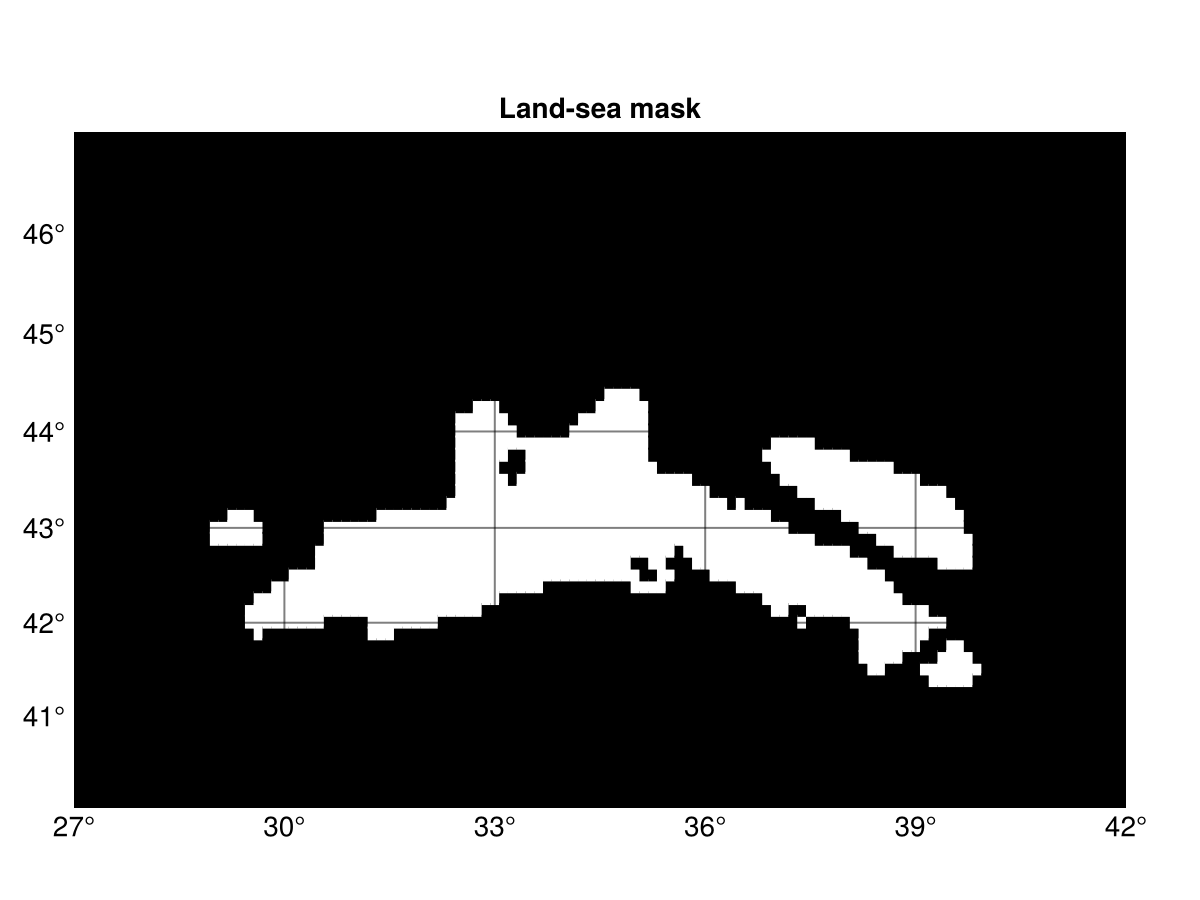

In [6]:
plot_mask(bx, by, mask[:, :, end], xticks = 24.0:3.0:45, yticks = 40:1.0:47.0)

Take out Marmara and Azov sea

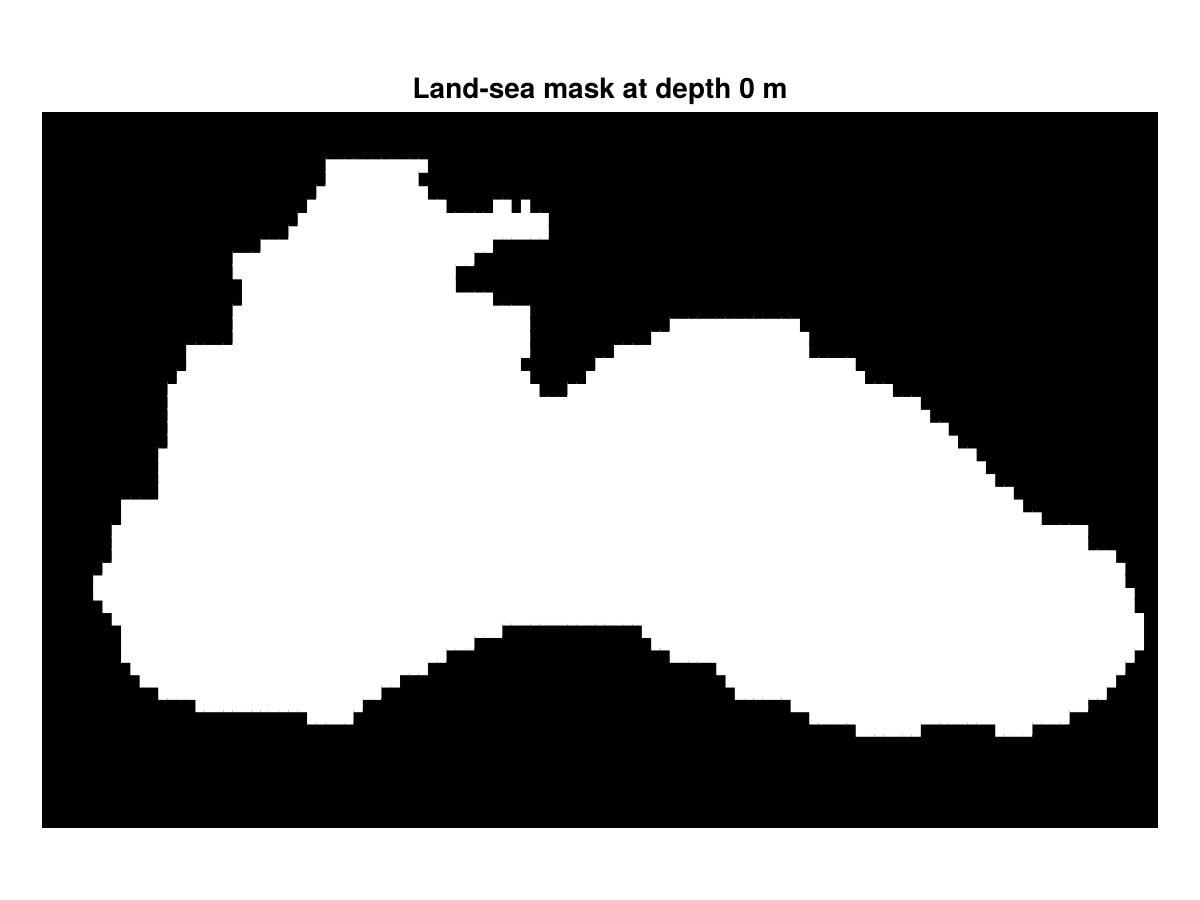

In [7]:
sel1 = (xi .> 34.75) .& (yi .> 45.10)
mask[sel1] .= false
sel1 = (xi .< 29.5) .& (yi .< 41.125)
mask[sel1] .= false

plot_mask(bx, by, mask[:, :, 1], depth = 0)

## Load salinity data

In [8]:
datafile = salinitybigfile
download_check(salinitybigfile, salinitybigfileURL)
value, lon, lat, depth, timeval, ids = DIVAnd.loadbigfile(datafile)
@show size(value)

[ Info: File already downloaded
[ Info: Loading data from 'big file' ../data/Salinity.bigfile


size(value) = (139230,)


(139230,)

In [9]:
deepestdata = 5500.0
lowestdata = 14.0
highestdata = 25.0

25.0

### Subset data 
Taking out Marmara and Azov sea

size(value) = (136854,)


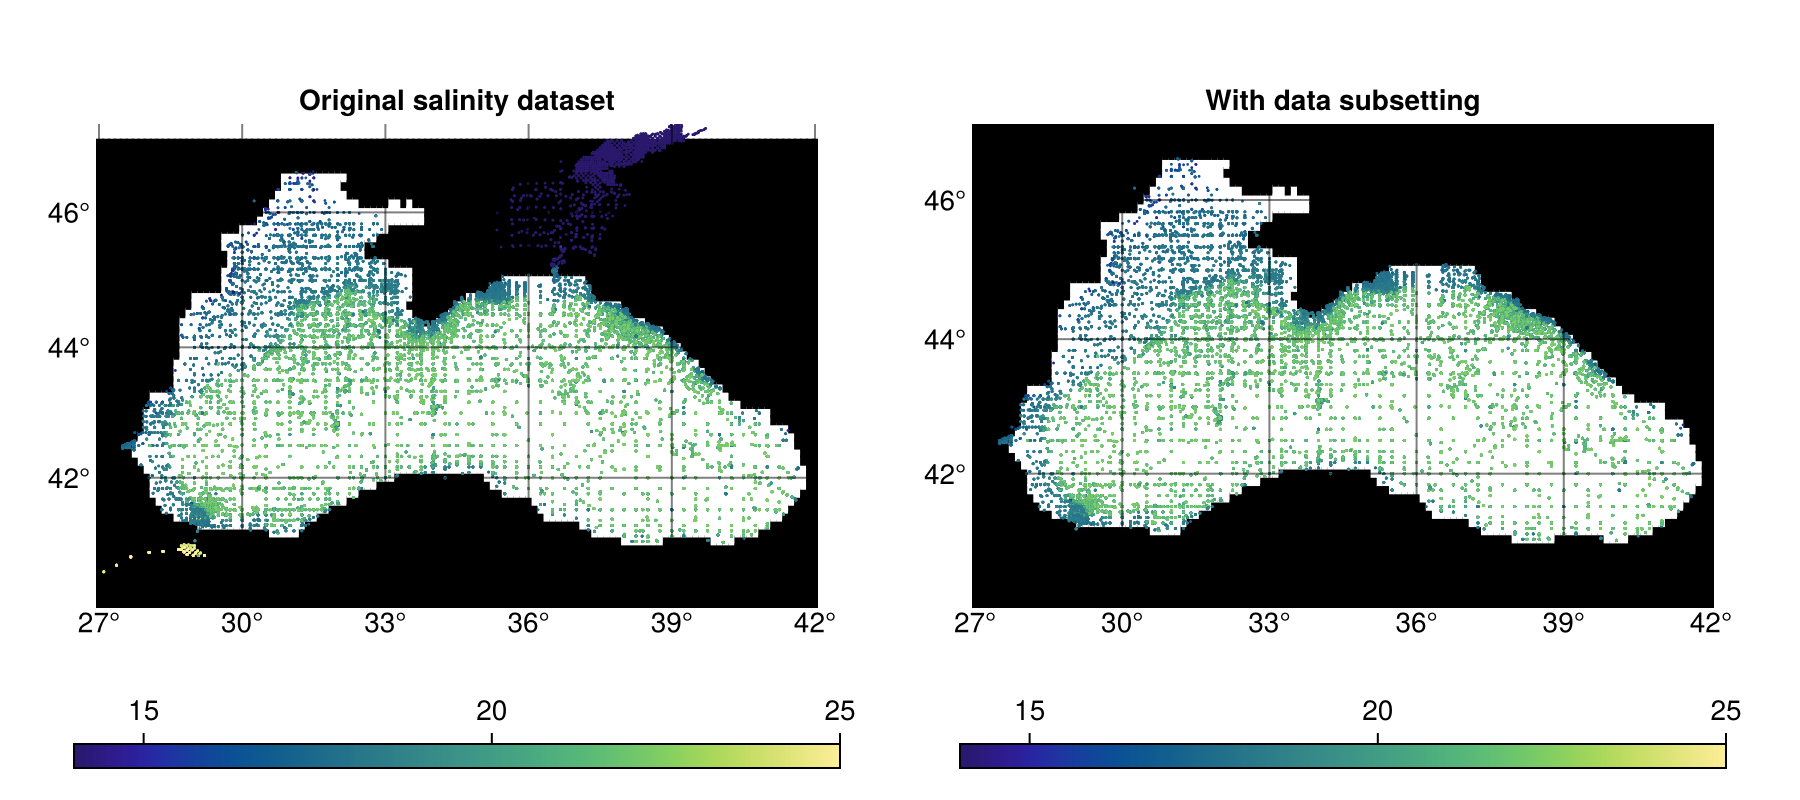

CairoMakie.Screen{IMAGE}


In [10]:
sel =
    (value .> lowestdata) .&
    (value .< highestdata) .&
    .~((lon .> 34.75) .& (lat .> 45.10)) .&
    .~((lon .< 29.5) .& (lat .< 41.125)) .&
    (depth .< deepestdata) .&
    (timeval .> DateTime(Date(1950)))

fig = Figure(size = (900, 400))
ax1 = GeoAxis(
    fig[1, 1],
    dest = "+proj=merc",
    xticks = 27.0:3.0:42.0,
    yticks = 40.0:2.0:48.0,
    title = "Original salinity dataset",
)
heatmap!(ax1, bx, by, mask[:, :, 1], colormap = Reverse(:binary))
sc1 = scatter!(
    ax1,
    lon,
    lat,
    color = value,
    markersize = 2,
    colorrange = [lowestdata, highestdata],
    colormap = cmapS,
)
Colorbar(fig[2, 1], sc1, vertical = false)

# Perform subsetting
value = value[sel]
lon = lon[sel]
lat = lat[sel]
depth = depth[sel]
timeval = timeval[sel]
ids = ids[sel]

@show(size(value))
ax2 = GeoAxis(
    fig[1, 2],
    dest = "+proj=merc",
    xticks = 27.0:3.0:42.0,
    yticks = 40.0:2.0:48.0,
    title = "With data subsetting",
)
heatmap!(ax2, bx, by, mask[:, :, 1], colormap = Reverse(:binary))
sc2 = scatter!(
    ax2,
    lon,
    lat,
    color = value,
    markersize = 2,
    colorrange = [lowestdata, highestdata],
    colormap = cmapS,
)
Colorbar(fig[2, 2], sc2, vertical = false)
display(fig)

### Observational error variance inflation factor

In [11]:
rdiag = 1.0 ./ DIVAnd.weight_RtimesOne((lon, lat, depth), (0.03, 0.03, 10));
@show (mean(rdiag));

[ Info: Computing weights using 1 CPU thread(s)


mean(rdiag) = 12.07981627420008


### Useful functions to define new coordinates

In [12]:
function dayinyear(x)
    return Dates.value(Date(x) - Date(Dates.year(x)))
end
function daysince1900(x)
    return Dates.value(Date(x) - Date(Dates.year(DateTime(1900))))
end

daysince1900 (generic function with 1 method)

### Prepare a new analysis space:
- depth, 
- day-in-a-year, 
- time-in-days-from-1900

In [13]:
coordinatesfordetrending = (depth, dayinyear.(timeval), daysince1900.(timeval));
tmin, tmax = extrema(daysince1900.(timeval))
maskt, (pmt, pnt, pot), (xit, yit, zit) =
    DIVAnd.DIVAnd_rectdom(depthr, 0:10:365, tmin:150:tmax);

In [14]:
sz = size(maskt)
lent3 = [15000 + 10 * depthr[i] for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]
lent2 = [150 + depthr[i] / 20 for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]
lent1 = [
    5 + (depthr[min(i + 1, sz[1])] - depthr[max(1, i - 1)]) for i = 1:sz[1],
    j = 1:sz[2], k = 1:sz[3]
];

Two user functions defining the two scales:
1. For the trend analysis, 
2. for the normal analysis.

In [15]:
function H1K1(data)
    K1d, s = DIVAnd.DIVAndrun(
        maskt,
        (pmt, pnt, pot),
        (xit, yit, zit),
        coordinatesfordetrending,
        data,
        (lent1, lent2, lent3),
        epsilon2 * rdiag;
        moddim = [0, 365, 0],
    )
    #K1d,s=DIVAndrun(mask[1],pm[1],xi[1],x,data,len[1],epsilon2)    
    return K1d, data .- DIVAnd_residual(s, K1d)
end
function H2K2(data)
    K2d, s = DIVAnd.DIVAndrun(
        mask,
        (pm, pn, po),
        (xi, yi, zi),
        (lon, lat, depth),
        data,
        (lenx, leny, lenz),
        epsilon2 * rdiag,
    )
    #K1d,s=DIVAndrun(mask[1],pm[1],xi[1],x,data,len[1],epsilon2)    
    return K2d, data .- DIVAnd_residual(s, K2d)
end

H2K2 (generic function with 1 method)

Simple analysis for the trend space

In [16]:
fdet, bidon = H1K1(value .- mean(value));

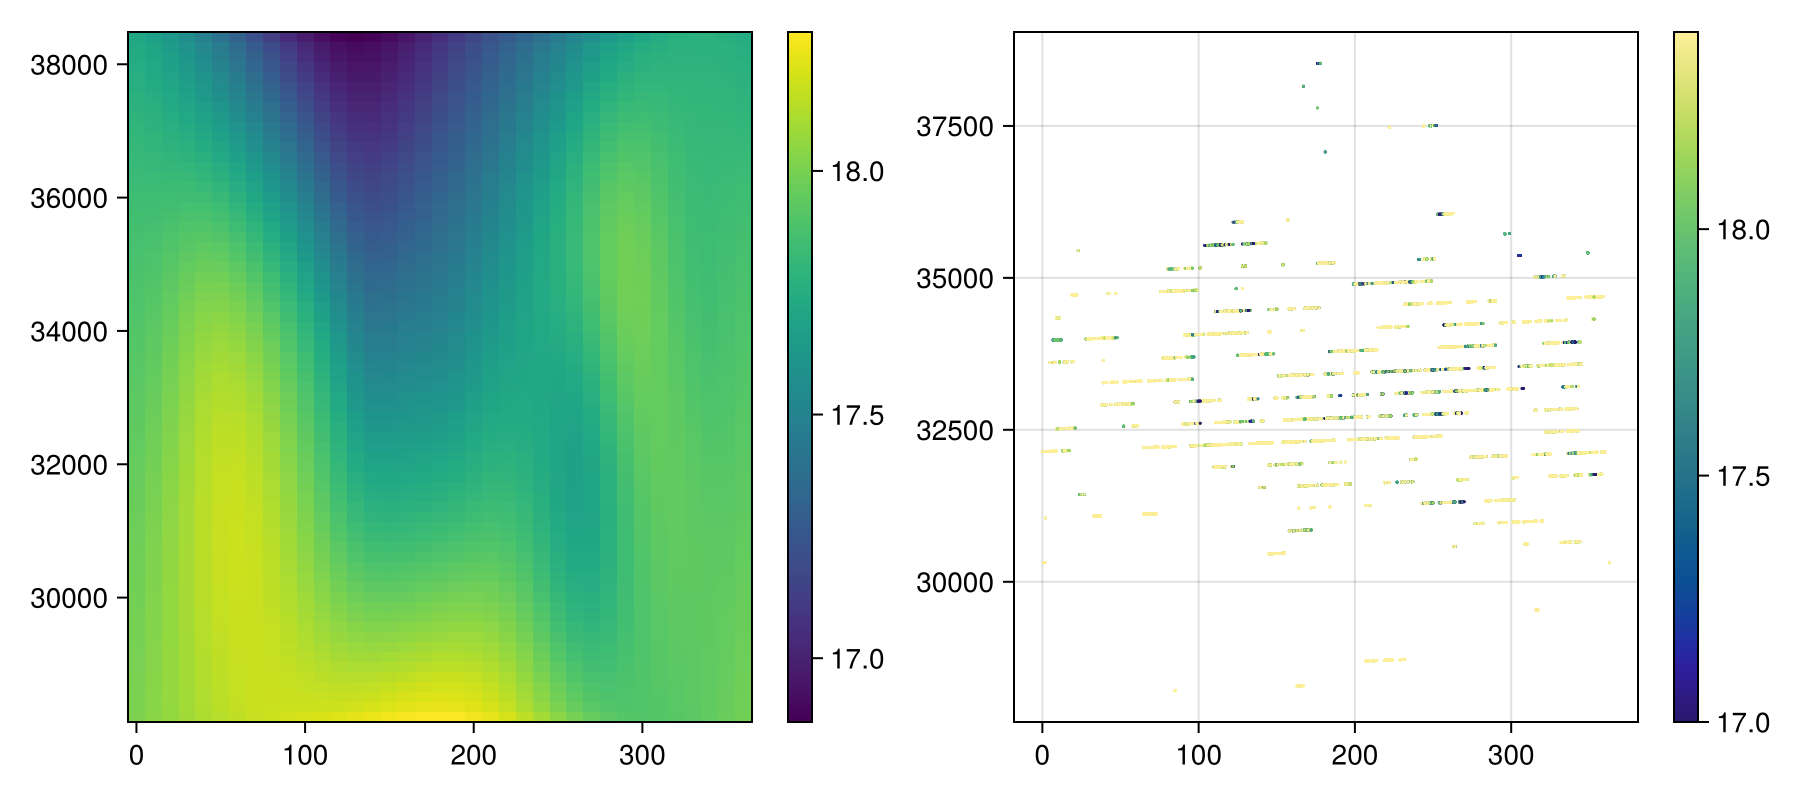

In [17]:
fig = Figure(size = (900, 400))
ax = Axis(fig[1, 1])
hm = heatmap!(ax, yit[1, :, 1], zit[1, 1, :], mean(value) .+ fdet[1, :, :])
Colorbar(fig[1, 2], hm)
ax = Axis(fig[1, 3])
sc = scatter!(
    ax,
    coordinatesfordetrending[2],
    coordinatesfordetrending[3],
    markersize = 2,
    color = value,
    colorrange = (17.0, 18.4),
    colormap = cmapS,
)
Colorbar(fig[1, 4], sc)
# colsize!(fig.layout, 1, Aspect(1, 0.65))
fig

Simple surface analysis

In [18]:
fsur, bidon = H2K2(value .- mean(value))
fsurori = fsur;

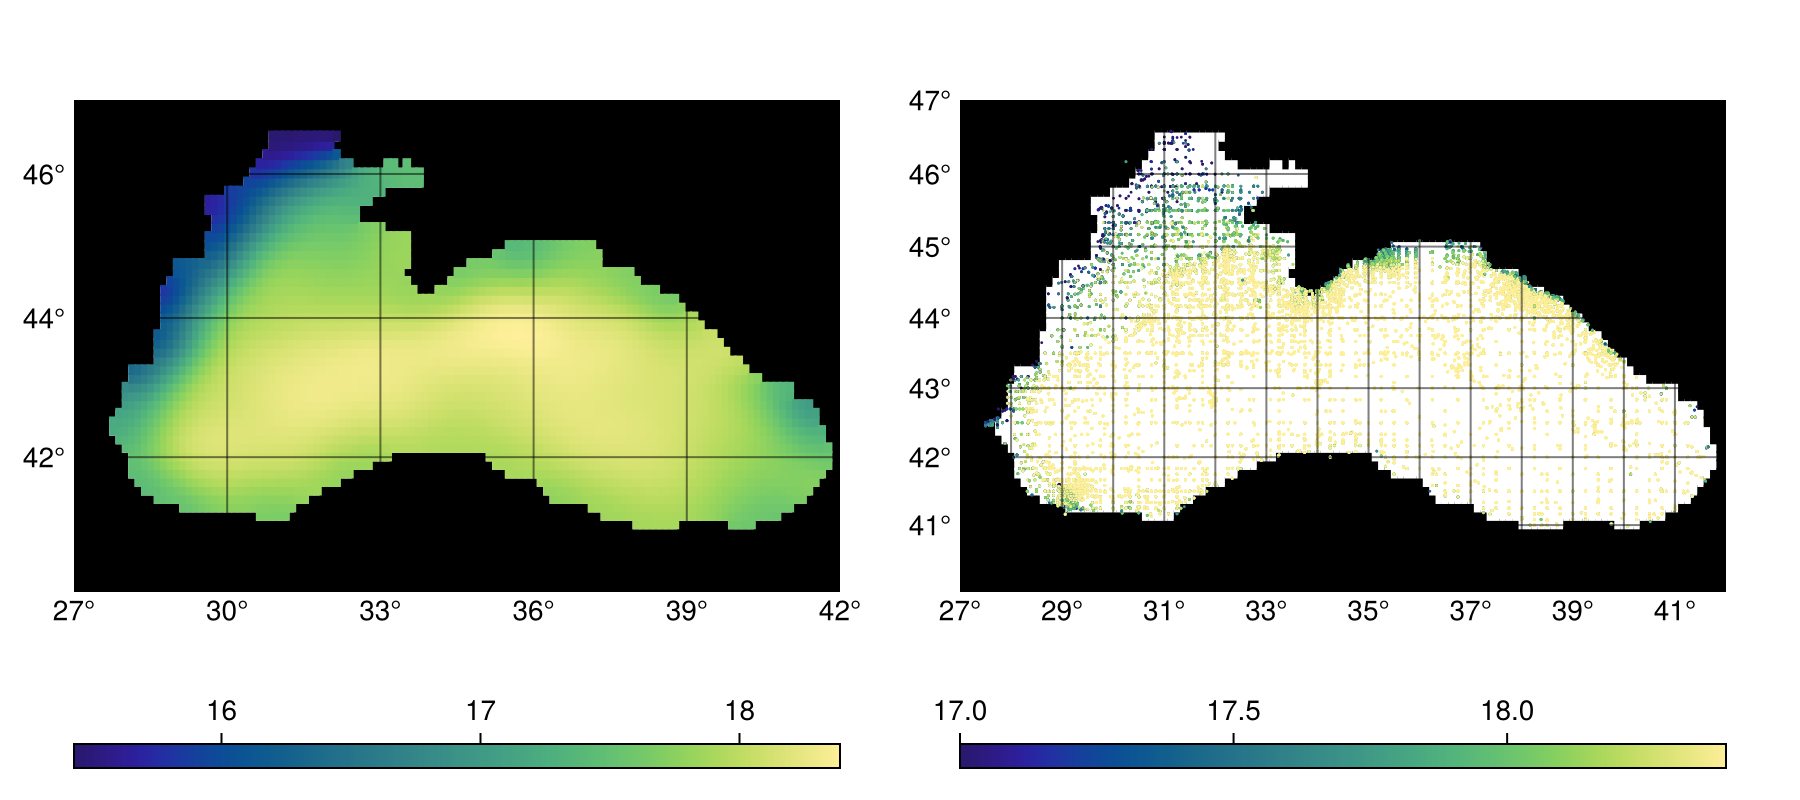

In [19]:
fig = Figure(size = (900, 400))
ga1 =
    GeoAxis(fig[1, 1], dest = "+proj=merc", xticks = 27.0:3.0:42.0, yticks = 40.0:2.0:48.0)
heatmap!(ga1, bx, by, mask[:, :, 1], colormap = Reverse(:binary))
hm = heatmap!(ga1, xi[:, 1, 1], yi[1, :, 1], mean(value) .+ fsur[:, :, 1], colormap = cmapS)
xlims!(ga1, bx[1], bx[end])
ylims!(ga1, by[1], by[end])

Colorbar(fig[2, 1], hm, vertical = false)
ga2 = GeoAxis(fig[1, 2], dest = "+proj=merc")
heatmap!(ga2, bx, by, mask[:, :, 1], colormap = Reverse(:binary))
sc = scatter!(
    ga2,
    lon,
    lat,
    markersize = 2,
    color = value,
    colorrange = (17.0, 18.4),
    colormap = cmapS,
)
xlims!(ga2, bx[1], bx[end])
ylims!(ga2, by[1], by[end])
Colorbar(fig[2, 2], sc, vertical = false)
# colsize!(fig.layout, 1, Aspect(1, 0.65))
fig

## Now detrending via scale separation

In [20]:
# ?scaleseparation

In [21]:
fdet, dd1, fsur, dd2 = scaleseparation(H1K1, H2K2, value .- mean(value); niter = 3);

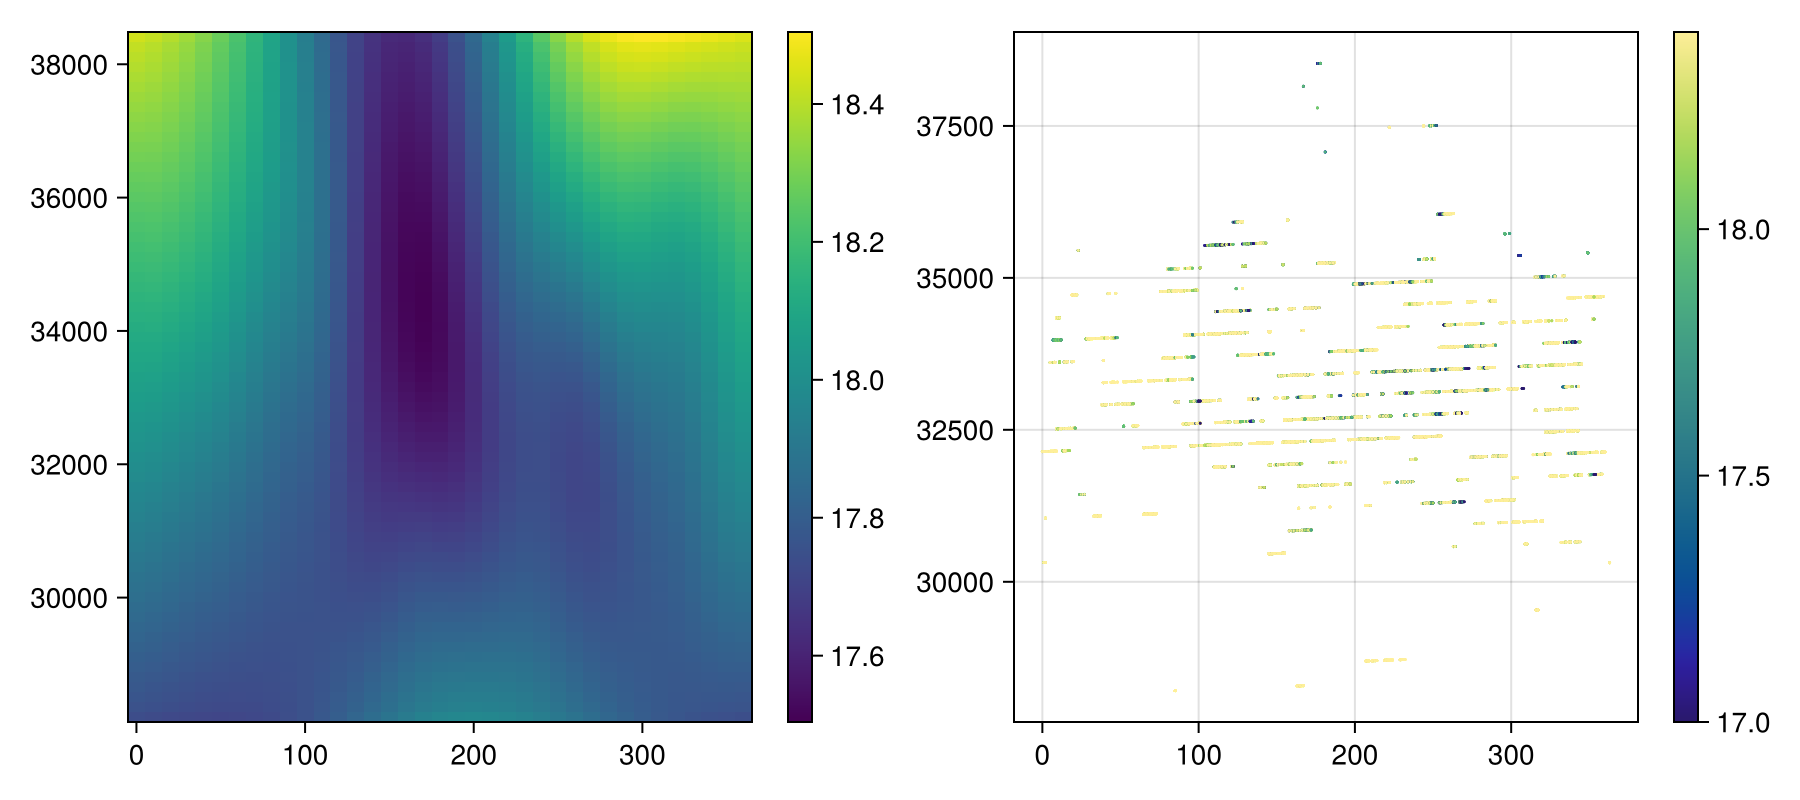

In [22]:
fig = Figure(size = (900, 400))
ax = Axis(fig[1, 1])
hm = heatmap!(ax, yit[1, :, 1], zit[1, 1, :], mean(value) .+ fdet[1, :, :])
Colorbar(fig[1, 2], hm)
ax = Axis(fig[1, 3])
sc = scatter!(
    ax,
    coordinatesfordetrending[2],
    coordinatesfordetrending[3],
    markersize = 2,
    color = value,
    colorrange = (17.0, 18.4),
    colormap = cmapS,
)
Colorbar(fig[1, 4], sc)
fig

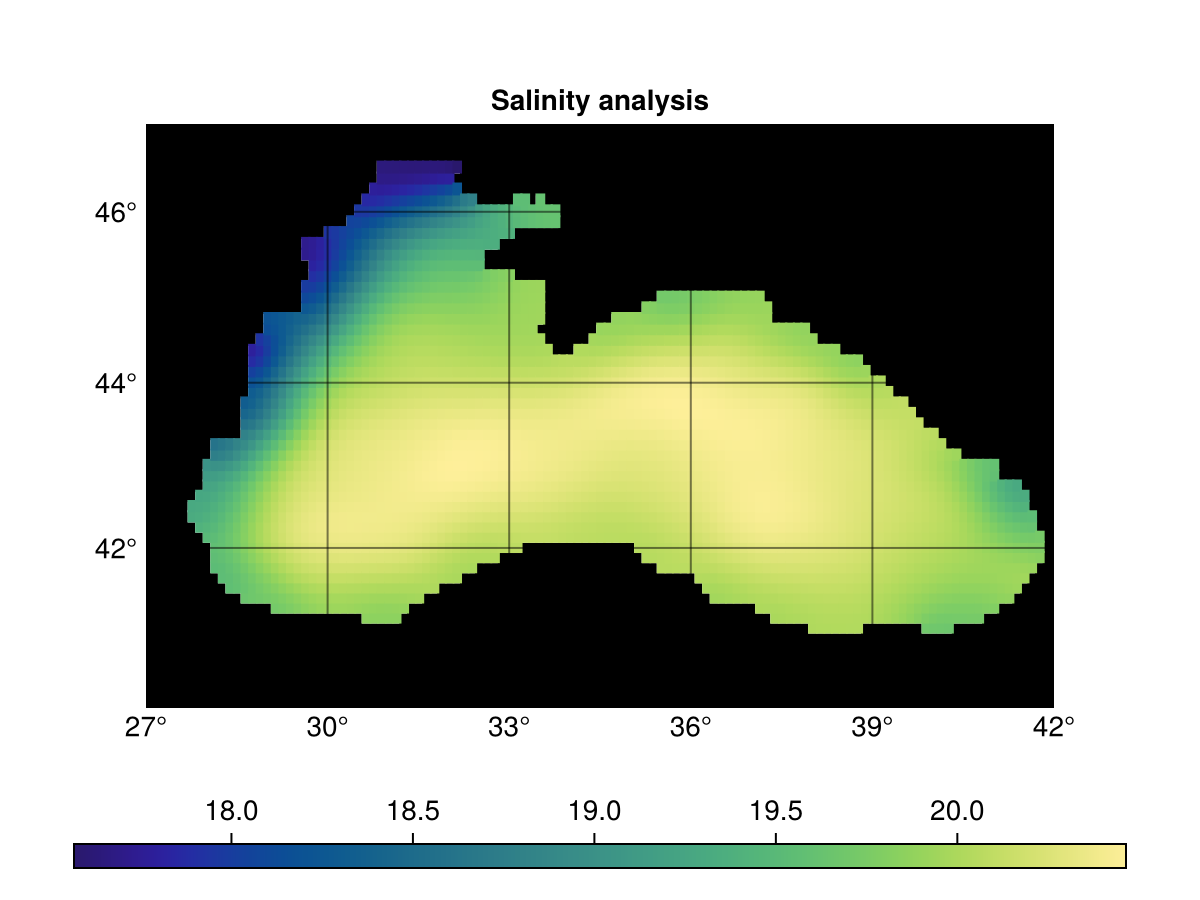

In [23]:
fig = Figure()
ga1 = GeoAxis(
    fig[1, 1],
    dest = "+proj=merc",
    title = "Salinity analysis",
    xticks = 27.0:3.0:42.0,
    yticks = 40.0:2.0:48.0,
)
heatmap!(ga1, bx, by, mask[:, :, 1], colormap = Reverse(:binary))
hm = heatmap!(ga1, xi[:, 1, 1], yi[1, :, 1], mean(value) .+ fsur[:, :, 1], colormap = cmapS)
Colorbar(fig[2, 1], hm, vertical = false)
xlims!(ga1, bx[1], bx[end])
ylims!(ga1, by[1], by[end])
fig

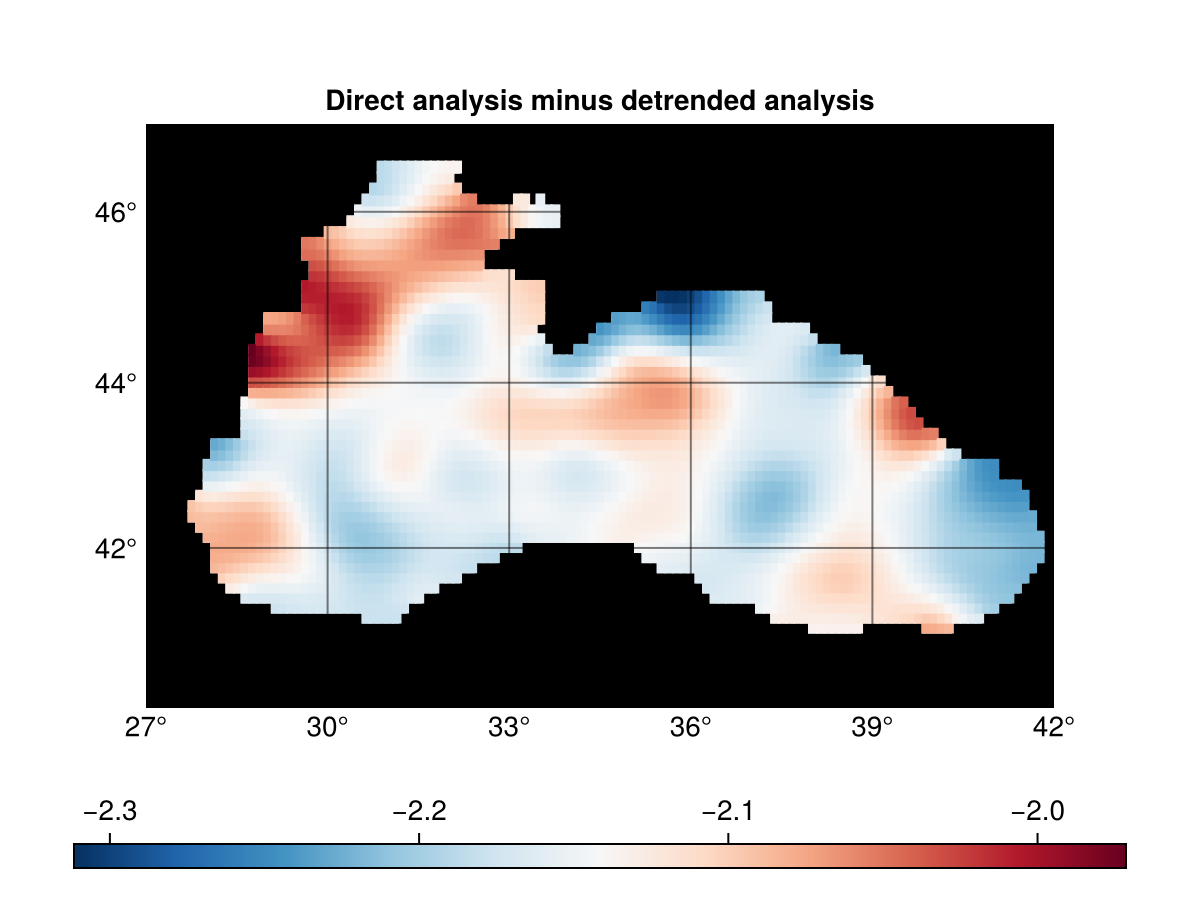

In [24]:
fig = Figure()
ga1 = GeoAxis(
    fig[1, 1],
    dest = "+proj=merc",
    title = "Direct analysis minus detrended analysis",
    xticks = 27.0:3.0:42.0,
    yticks = 40.0:2.0:48.0,
)
heatmap!(ga1, bx, by, mask[:, :, 1], colormap = Reverse(:binary))
hm = heatmap!(
    ga1,
    xi[:, 1, 1],
    yi[1, :, 1],
    fsurori[:, :, 1] - fsur[:, :, 1],
    colormap = Reverse(:RdBu),
)
Colorbar(fig[2, 1], hm, vertical = false)
xlims!(ga1, bx[1], bx[end])
ylims!(ga1, by[1], by[end])
fig

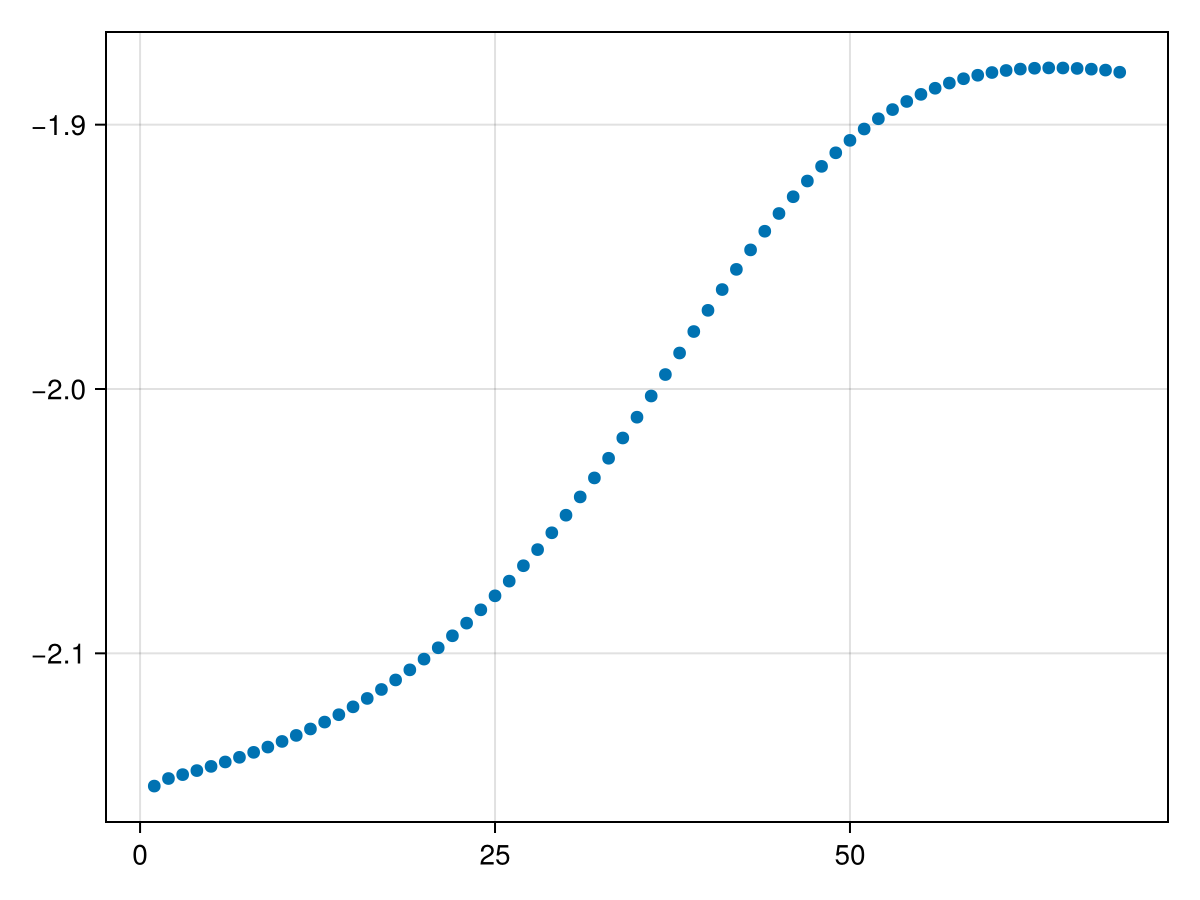

In [25]:
plot((fdet[1, 10, :]))

In [26]:
fsurs = deepcopy(fsur) .+ mean(value);

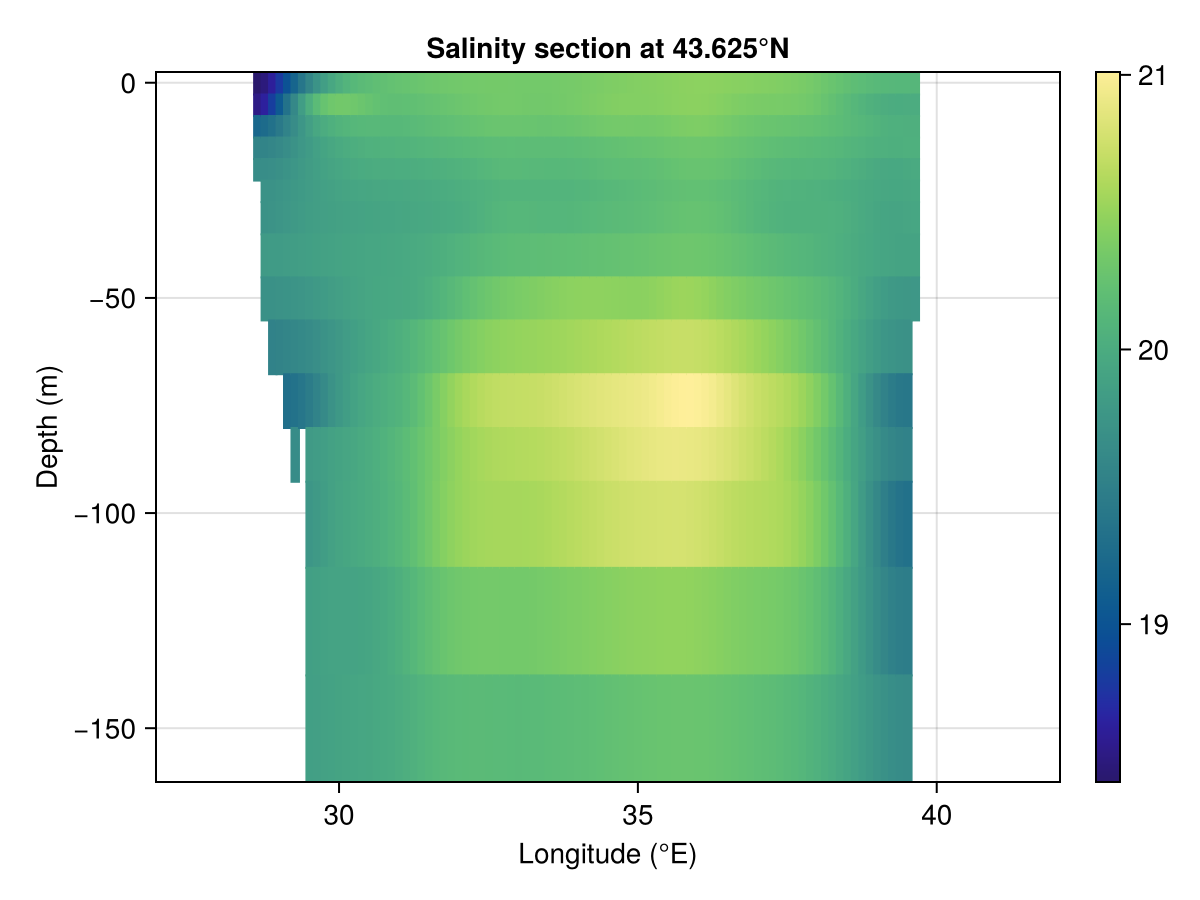

In [27]:
latindex = 30
fig = Figure()
ax = Axis(
    fig[1, 1],
    title = "Salinity section at $(latr[latindex])°N",
    ylabel = "Depth (m)",
    xlabel = "Longitude (°E)",
)
hm = heatmap!(
    ax,
    xi[:, latindex, 1],
    -zi[1, latindex, 1:15],
    fsurs[:, latindex, 1:15],
    colormap = cmapS,
)
Colorbar(fig[1, 2], hm)
fig

## Now temperature
### Load temperature data

In [28]:
download_check(temperaturebigfile, temperaturebigfileURL)
value, lon, lat, depth, timeval, ids =
DIVAnd.loadbigfile(joinpath(datadir, temperaturebigfile));
@show size(value)

[ Info: Download file ../data/Temperature.bigfile


x = "1929-11T11:52"

[ Info: Loading data from 'big file' ../data/../data/Temperature.bigfile



size(value) = (307169,)


(307169,)

### Subset data

size(value) = (258016,)


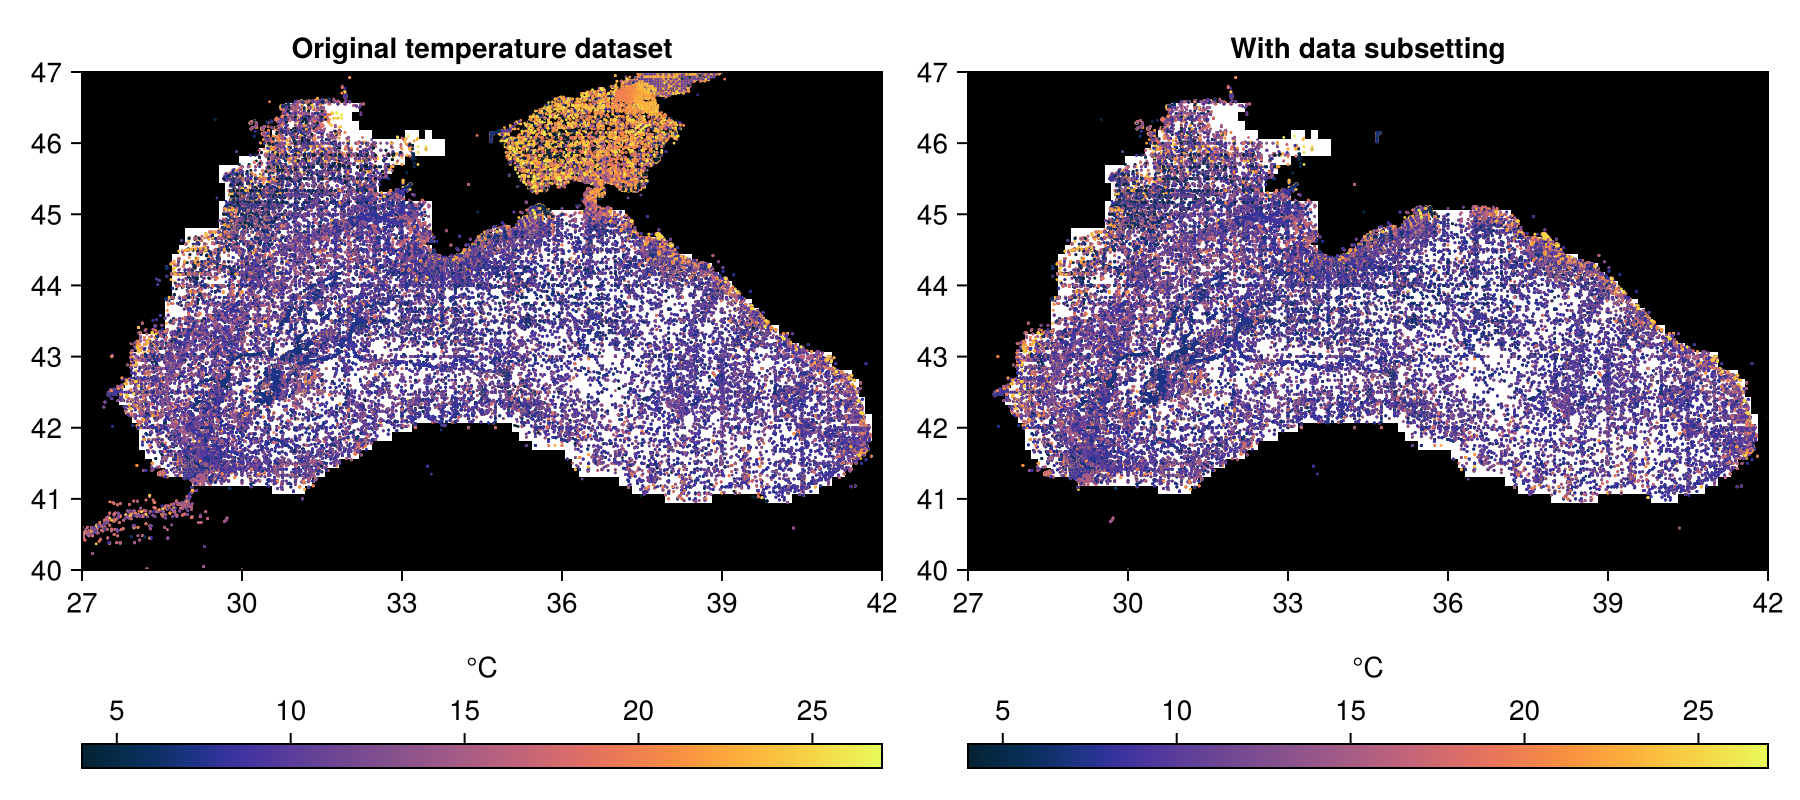

CairoMakie.Screen{IMAGE}


In [29]:
lowestdata = 4
highestdata = 27

sel =
    (value .> lowestdata) .&
    (value .< highestdata) .&
    .~((lon .> 34.75) .& (lat .> 45.10)) .&
    .~((lon .< 29.5) .& (lat .< 41.125)) .&
    (depth .< deepestdata) .&
    (timeval .> DateTime(Date(1950)))


fig = Figure(size = (900, 400))
ax1 = Axis(fig[1, 1], title = "Original temperature dataset")
heatmap!(ax1, bx, by, mask[:, :, 1], colormap = Reverse(:binary))
sc1 = scatter!(
    ax1,
    lon,
    lat,
    color = value,
    markersize = 2,
    colorrange = [lowestdata, highestdata],
    colormap = cmapT,
)
xlims!(ax1, bx[1], bx[end])
ylims!(ax1, by[1], by[end])
Colorbar(fig[2, 1], sc1, vertical = false, label = "°C")

# Perform subsetting
value = value[sel]
lon = lon[sel]
lat = lat[sel]
depth = depth[sel]
timeval = timeval[sel]
ids = ids[sel]

@show(size(value))

ax2 = Axis(fig[1, 2], title = "With data subsetting")
heatmap!(ax2, bx, by, mask[:, :, 1], colormap = Reverse(:binary))
sc2 = scatter!(
    ax2,
    lon,
    lat,
    color = value,
    markersize = 2,
    colorrange = [lowestdata, highestdata],
    colormap = cmapT,
)
xlims!(ax2, bx[1], bx[end])
ylims!(ax2, by[1], by[end])
Colorbar(fig[2, 2], sc2, vertical = false, label = "°C")
display(fig)

In [30]:
coordinatesfordetrending = (depth, dayinyear.(timeval), daysince1900.(timeval));
#tmin,tmax=extrema(daysince1900.(timeval))
maskt, (pmt, pnt, pot), (xit, yit, zit) =
    DIVAnd.DIVAnd_rectdom(depthr, 0:10:365, tmin:150:tmax);

In [31]:
function H1K1t(data)
    K1d, s = DIVAnd.DIVAndrun(
        maskt,
        (pmt, pnt, pot),
        (xit, yit, zit),
        coordinatesfordetrending,
        data,
        (lent1, lent2, lent3),
        epsilon2 * rdiag;
        moddim = [0, 365, 0],
    )
    #K1d,s=DIVAndrun(mask[1],pm[1],xi[1],x,data,len[1],epsilon2)    
    return K1d, data - DIVAnd_residual(s, K1d)
end
function H2K2t(data)
    K2d, s = DIVAnd.DIVAndrun(
        mask,
        (pm, pn, po),
        (xi, yi, zi),
        (lon, lat, depth),
        data,
        (lenx, leny, lenz),
        epsilon2 * rdiag,
    )
    #K1d,s=DIVAndrun(mask[1],pm[1],xi[1],x,data,len[1],epsilon2)    
    return K2d, data - DIVAnd_residual(s, K2d)
end

H2K2t (generic function with 1 method)

In [32]:
rdiag = 1.0 ./ DIVAnd.weight_RtimesOne((lon, lat, depth), (0.03, 0.03, 10));
mean(rdiag)

[ Info: Computing weights using 1 CPU thread(s)


146.7475023375073

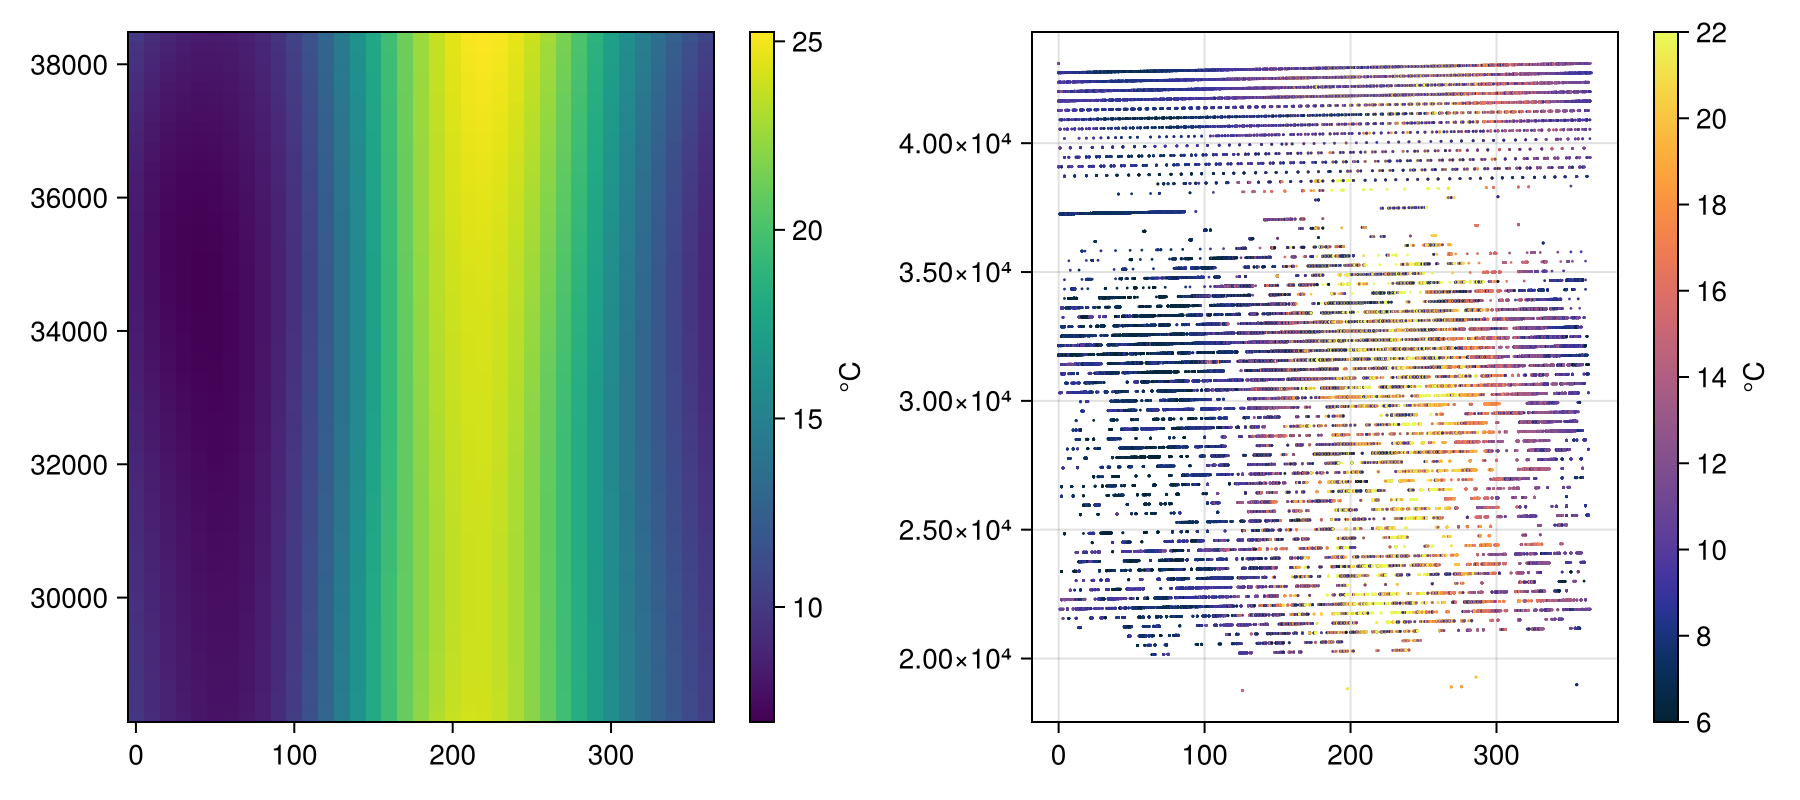

In [33]:
fdet, bidon = H1K1t(value .- mean(value));

fig = Figure(size = (900, 400))
ax = Axis(fig[1, 1])
hm = heatmap!(ax, yit[1, :, 1], zit[1, 1, :], mean(value) .+ fdet[1, :, :])
Colorbar(fig[1, 2], hm, label = "°C")
ax = Axis(fig[1, 3])
sc = scatter!(
    ax,
    coordinatesfordetrending[2],
    coordinatesfordetrending[3],
    markersize = 2,
    color = value,
    colorrange = (6.0, 22.0),
    colormap = cmapT,
)
Colorbar(fig[1, 4], sc, label = "°C")
# colsize!(fig.layout, 1, Aspect(1, 0.65))
fig

In [34]:
fsur, bidon = H2K2t(value .- mean(value))
fsurori = fsur;

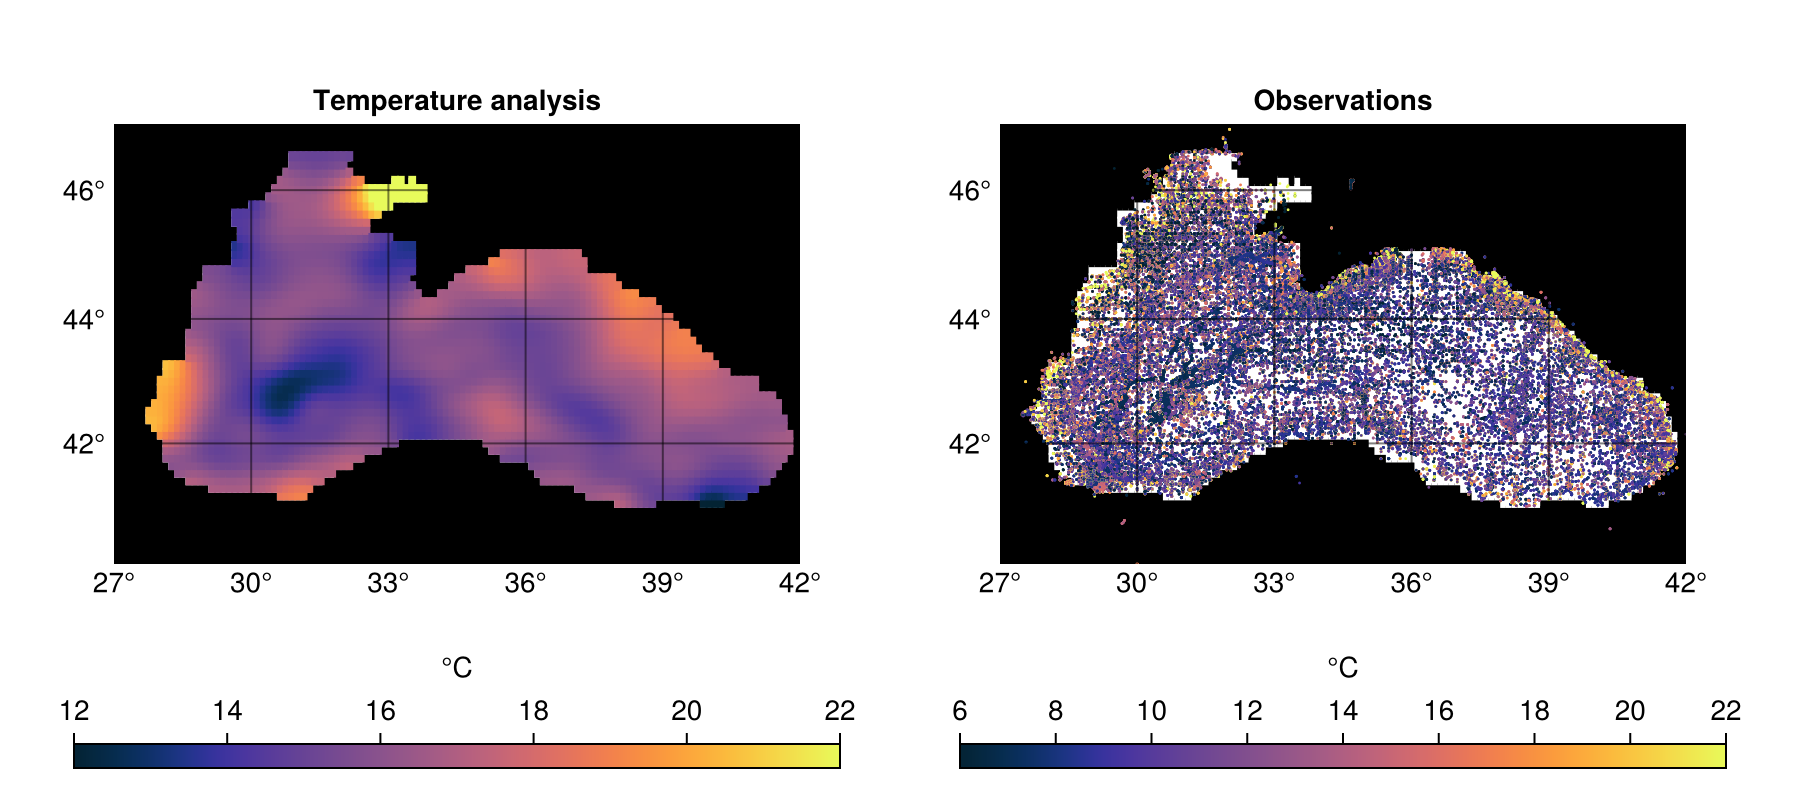

In [35]:
fig = Figure(size = (900, 400))
ga1 = GeoAxis(
    fig[1, 1],
    dest = "+proj=merc",
    title = "Temperature analysis",
    xticks = 27.0:3.0:42.0,
    yticks = 40.0:2.0:48.0,
)
heatmap!(ga1, bx, by, mask[:, :, 1], colormap = Reverse(:binary))
hm = heatmap!(
    ga1,
    xi[:, 1, 1],
    yi[1, :, 1],
    mean(value) .+ fsur[:, :, 1],
    colormap = cmapT,
    colorrange = [12.0, 22.0],
)
Colorbar(fig[2, 1], hm, vertical = false, label = "°C")
xlims!(ga1, bx[1], bx[end])
ylims!(ga1, by[1], by[end])

ga2 = GeoAxis(
    fig[1, 2],
    dest = "+proj=merc",
    title = "Observations",
    xticks = 27.0:3.0:42.0,
    yticks = 40.0:2.0:48.0,
)
heatmap!(ga2, bx, by, mask[:, :, 1], colormap = Reverse(:binary))
sc = scatter!(
    ga2,
    lon,
    lat,
    markersize = 2,
    color = value,
    colorrange = [6.0, 22.0],
    colormap = cmapT,
);
Colorbar(fig[2, 2], sc, vertical = false, label = "°C")
xlims!(ga2, bx[1], bx[end])
ylims!(ga2, by[1], by[end])

fig

In [36]:
fdett, dd1, fsurt, dd2 = scaleseparation(H1K1t, H2K2t, value .- mean(value); niter = 3);

In [37]:
fsurt = fsurt .+ mean(value);

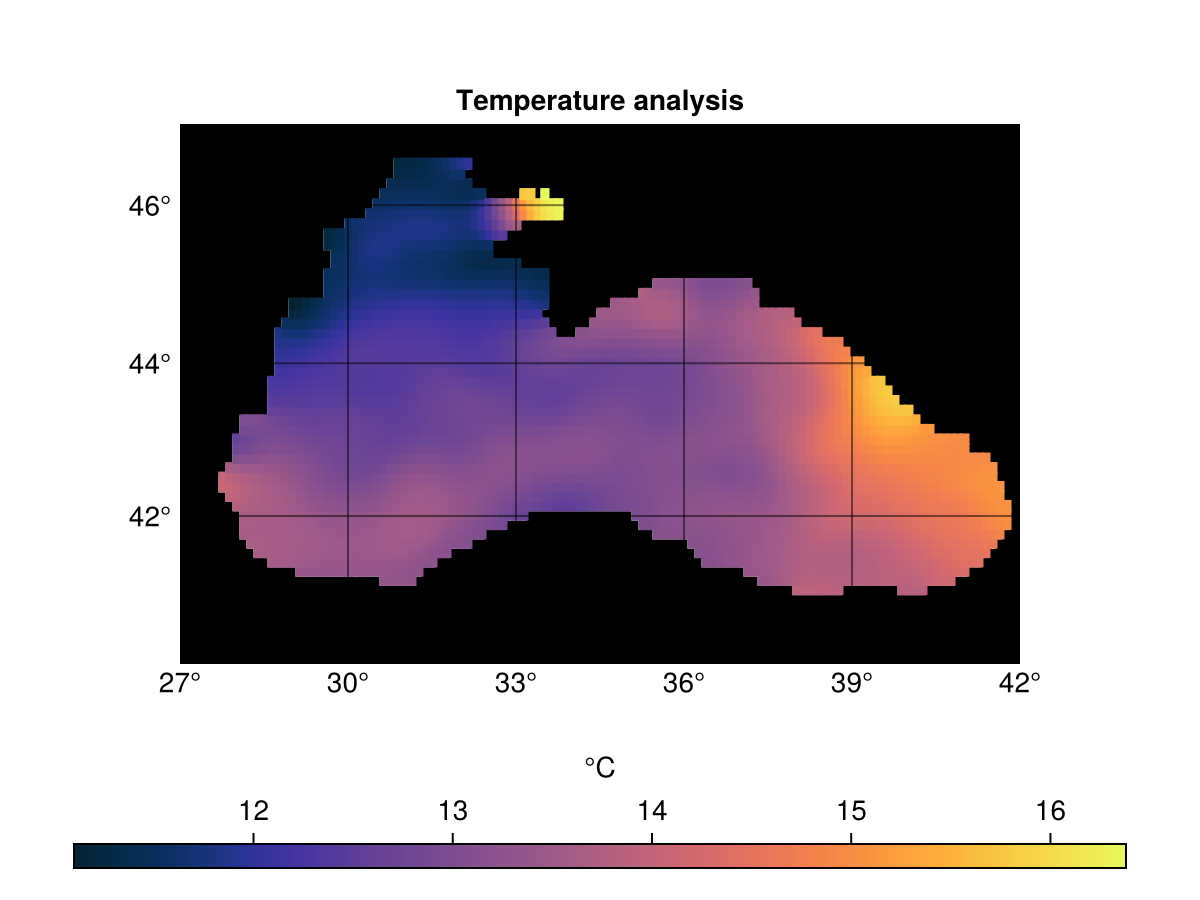

In [38]:
fig = Figure()
ga1 = GeoAxis(
    fig[1, 1],
    dest = "+proj=merc",
    title = "Temperature analysis",
    xticks = 27.0:3.0:42.0,
    yticks = 40.0:2.0:48.0,
)
heatmap!(ga1, bx, by, mask[:, :, 1], colormap = Reverse(:binary))
hm = heatmap!(ga1, xi[:, 1, 1], yi[1, :, 1], fsurt[:, :, 1], colormap = cmapT)
Colorbar(fig[2, 1], hm, vertical = false, label = "°C")
xlims!(ga1, bx[1], bx[end])
ylims!(ga1, by[1], by[end])
fig

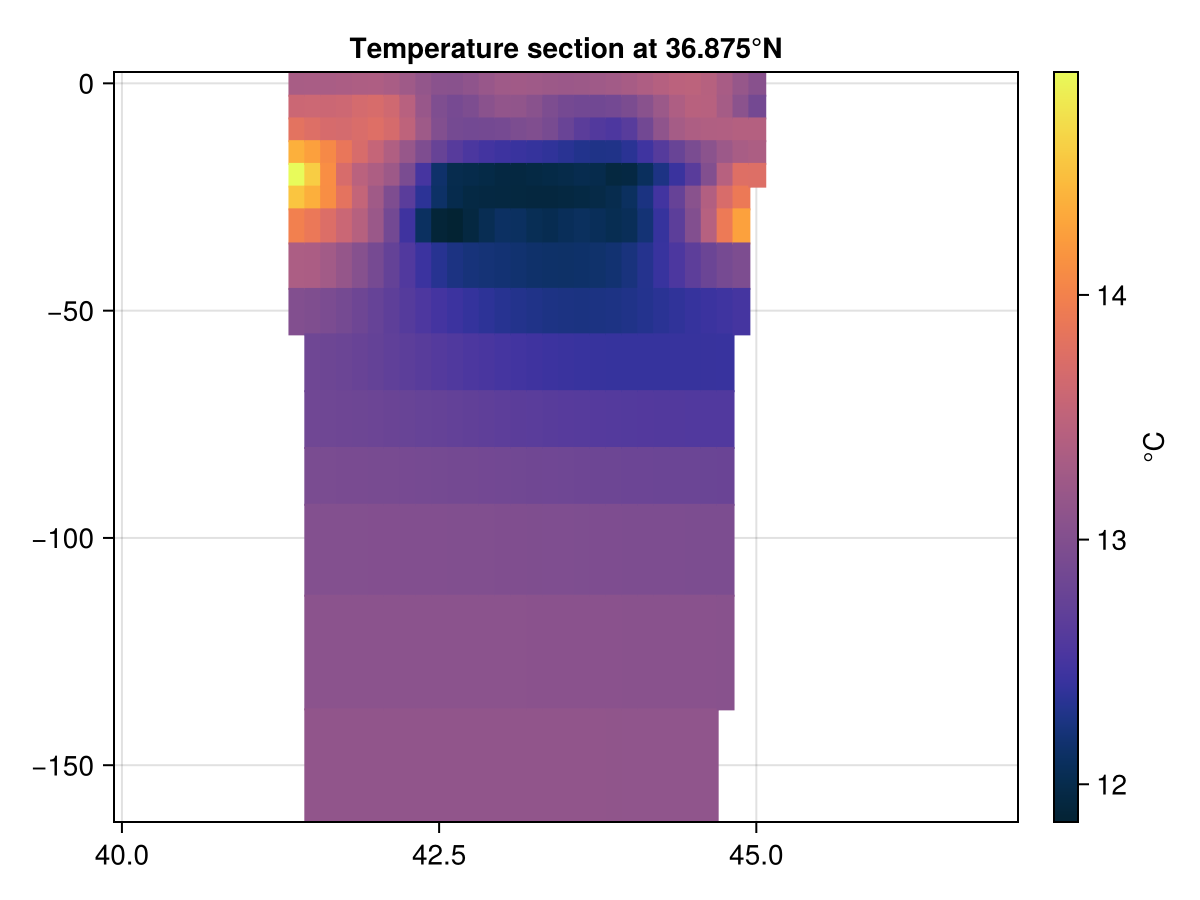

In [39]:
lonindex = 80
fig = Figure()
ax = Axis(fig[1, 1], title = "Temperature section at $(lonr[lonindex])°N")
hm = heatmap!(
    ax,
    yi[lonindex, :, 1],
    -zi[lonindex, 1, 1:15],
    fsurt[lonindex, :, 1:15],
    colormap = cmapT,
)
Colorbar(fig[1, 2], hm, label = "°C")
fig

## Geostrophic calculation using level of no motion

In [40]:
FN = zeros(size(depthr)[1])
dens = PhysOcean.density.(fsurs, fsurt, 0) .- 1025.0

for iz = 1:size(depthr)[1]
    velocities, eta, Vflux =
        geostrophy(mask, dens, (pm, pn, po), (xi, yi, zi); znomotion = iz)
    eta = eta .- mean(eta)
    FN[iz] = mean(Vflux[1] .^ 2) .+ mean(Vflux[2] .^ 2)
end

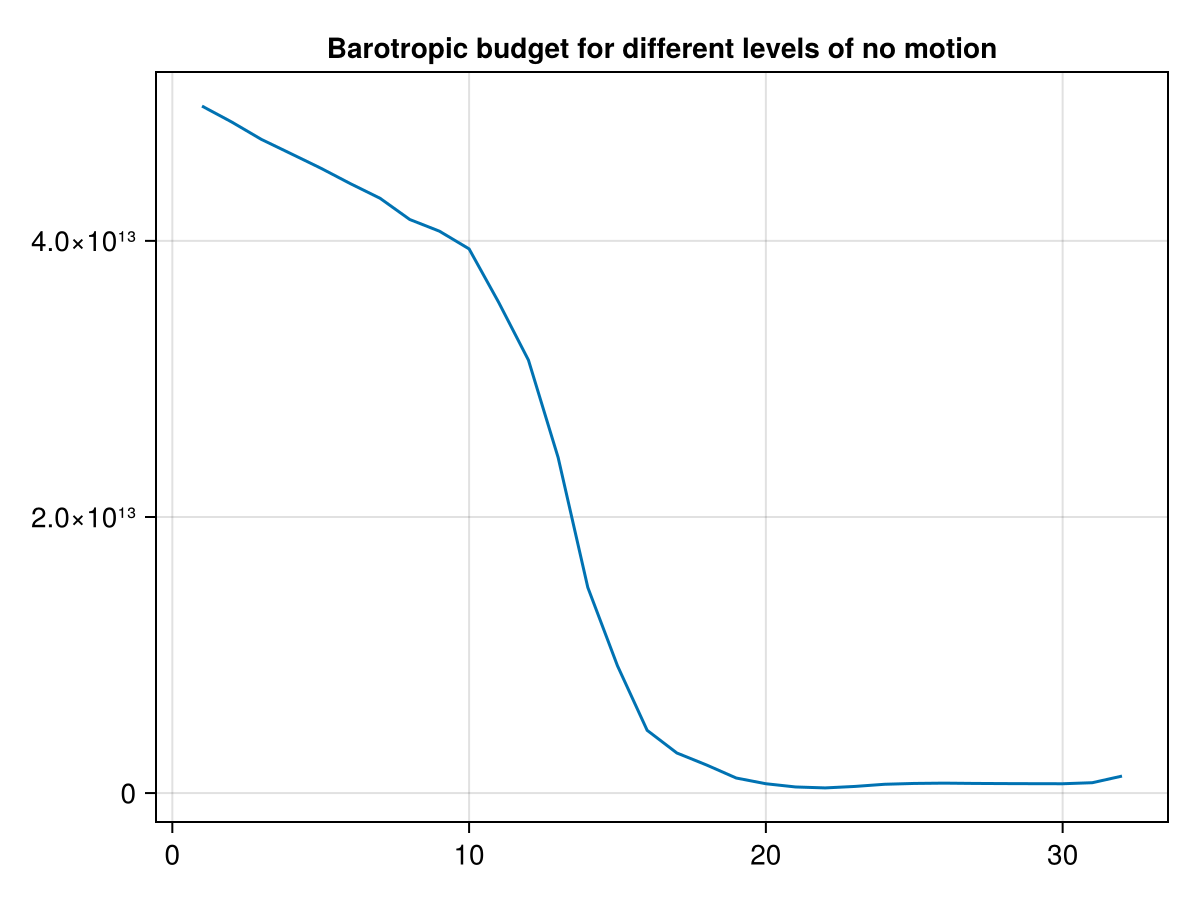

In [41]:
fig = Figure()
ax = Axis(fig[1, 1], title = "Barotropic budget for different levels of no motion")
lines!(ax, FN)
fig

### Just an arbitrary level, to be corrected later

In [42]:
minimum(FN), findmin(FN)[2]

(3.730110975481469e11, 22)

In [43]:
iz = findmin(FN)[2]
@show iz
iz = 15
velocities, eta, Vflux = geostrophy(mask, dens, (pm, pn, po), (xi, yi, zi); znomotion = iz);
eta = eta .- mean(eta);
eta = DIVAnd_filter3(eta, NaN, 10)
velocities, eta, Vflux = geostrophy(mask, dens, (pm, pn, po), (xi, yi, zi); ssh = eta);

iz = 22


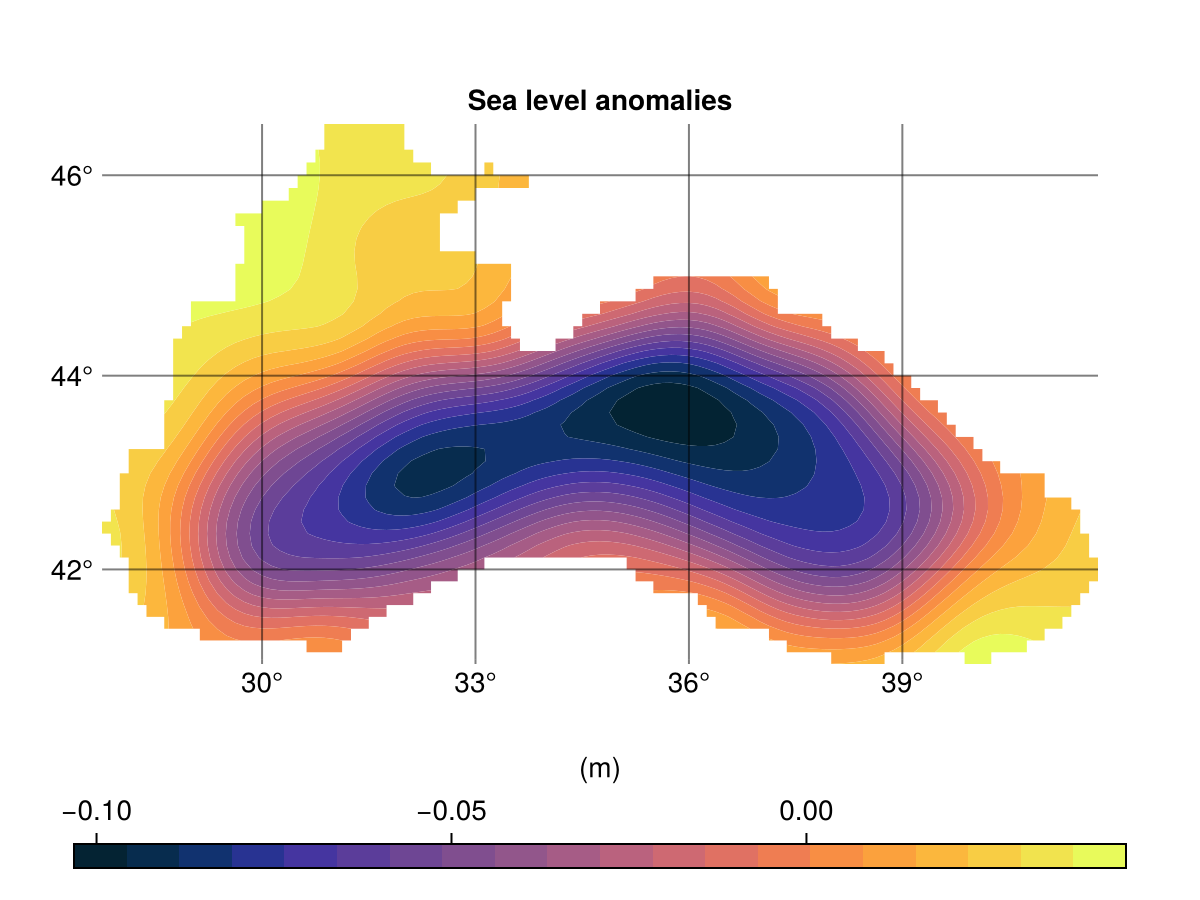

In [44]:
fig = Figure()
ga = GeoAxis(
    fig[1, 1],
    dest = "+proj=merc",
    title = "Sea level anomalies",
    xticks = 27.0:3.0:42.0,
    yticks = 40.0:2.0:48.0,
)
cont = contourf!(
    ga,
    xi[:, 1, 1],
    yi[1, :, 1],
    eta .+ 0 * fsurt[:, :, 1],
    levels = 20,
    colormap = cmapT,
)
Colorbar(fig[2, 1], cont, vertical = false, label = "(m)")
fig

Geostrophic calculation with level of not motion provides non-zero global fluxes:

In [45]:
mean(Vflux[1] .^ 2) + mean(Vflux[2] .^ 2)

1.2721683120833238e13

Try the correction term 

In [46]:
x = rand(1);
y = rand(1);
f = x

h = deepestpoint(mask, zi)
len = 1
epsilon2 = 10000
rfluxes = 0.000001

# Need to scale fluxes by f/g
gsf = (earthgravity.(yi)./coriolisfrequency.(yi))[:, :, 1]
fi, s = DIVAndrun(
    mask[:, :, 1],
    (pm[:, :, 1], pn[:, :, 1]),
    (xi[:, :, 1], yi[:, :, 1]),
    (x, y),
    f,
    len,
    epsilon2;
    topographyforfluxes = (gsf .* h, gsf .* h),
    fluxes = Vflux,
    epsfluxes = rfluxes,
    alphabc = 1,
    alpha = [1, 0, 1],
);

In [47]:
fim = deepcopy(fi);
fi[isnan.(fi)] .= 0.0;

In [48]:
velafter, etaafter, Vfluxafter =
    geostrophy(mask, dens, (pm, pn, po), (xi, yi, zi); ssh = eta + fi);

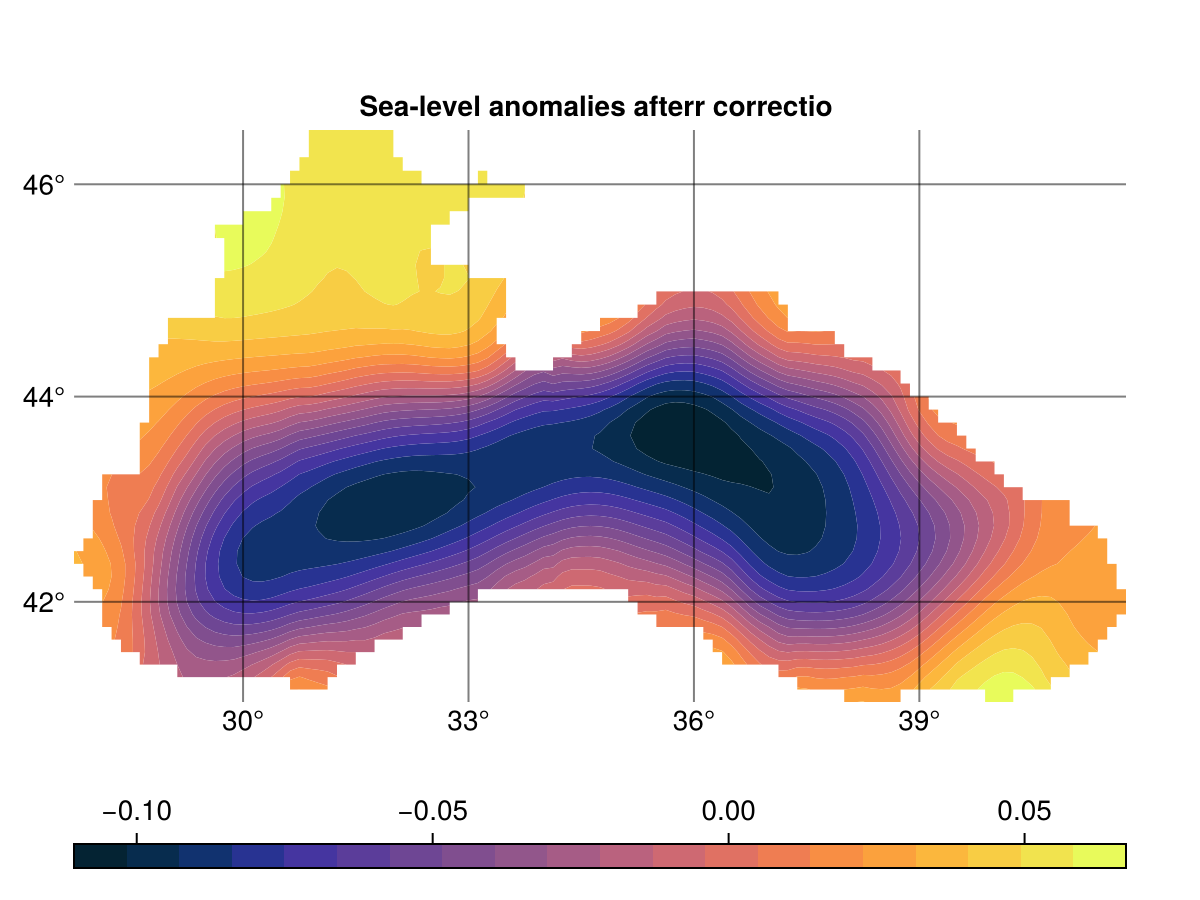

In [49]:
fig = Figure()
ga = GeoAxis(
    fig[1, 1],
    dest = "+proj=merc",
    title = "Sea-level anomalies afterr correctio ",
    xticks = 27.0:3.0:42.0,
    yticks = 40.0:2.0:48.0,
)
cont = contourf!(
    ga,
    xi[:, 1, 1],
    yi[1, :, 1],
    etaafter + 0 * fim,
    levels = 20,
    colormap = cmapT,
)
Colorbar(fig[2, 1], cont, vertical = false)
fig

Now much lower global fluxes

In [50]:
mean(Vfluxafter[1] .^ 2) + mean(Vfluxafter[2] .^ 2)

1.7670611566435376e11

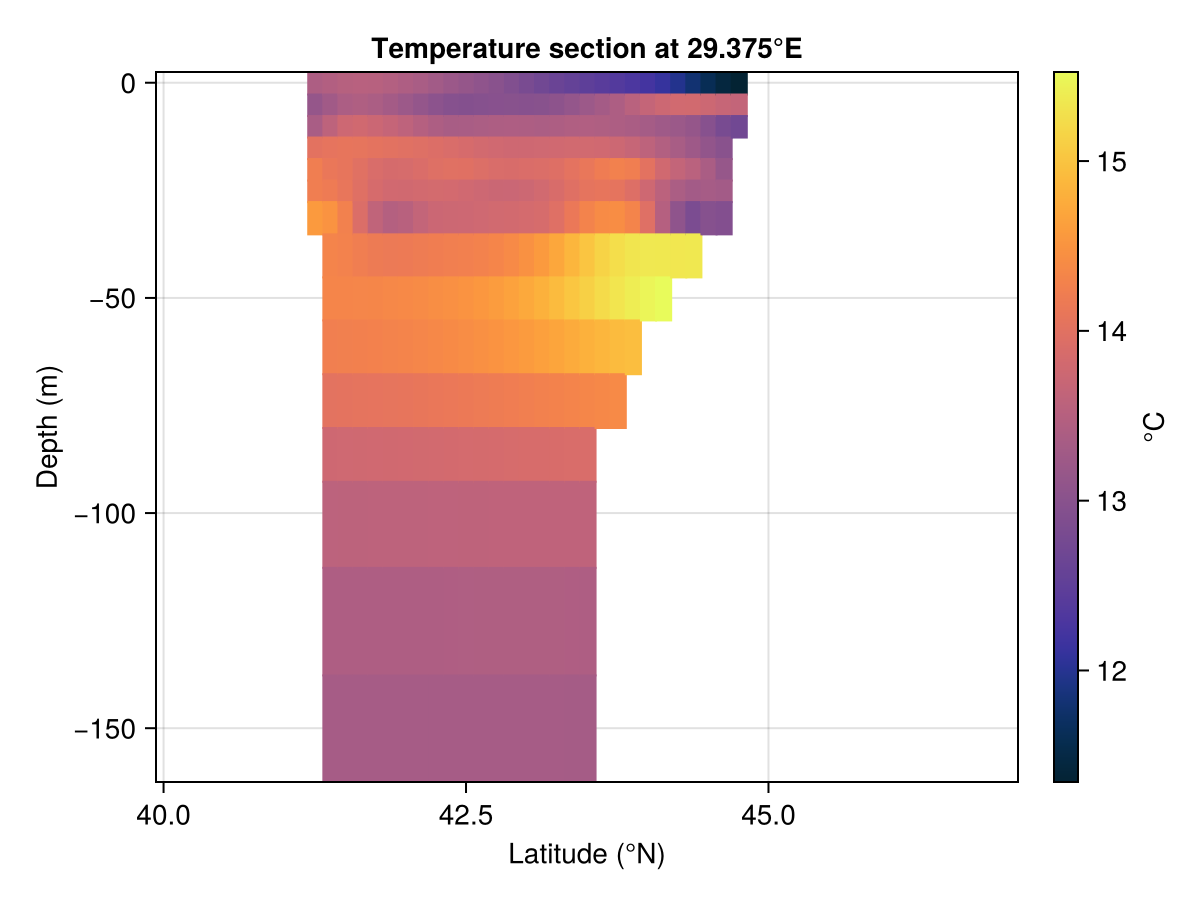

In [51]:
ind = 20
fig = Figure()
ax = Axis(
    fig[1, 1],
    title = "Temperature section at $(xi[ind])°E",
    ylabel = "Depth (m)",
    xlabel = "Latitude (°N)",
)
hm = heatmap!(ax, yi[ind, :, 1], -zi[ind, 1, 1:15], fsurt[ind, :, 1:15], colormap = cmapT)
Colorbar(fig[1, 2], hm, label = "°C")
fig